In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from TrackReconstruction_functions import *


# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_2nuBB_slim.h5","hits")

# hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_nexus.h5',"MC/hits")
# hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_1mm_smear.h5',"MC/hits")
# hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_4mm_smear.h5',"MC/hits")

# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim.h5","MC/hits")
# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim_smear.h5","hits")
# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim_smear_1mmbin.h5","hits")

# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_1mmstep_high_E_slim_smear.h5","hits")


# hits = pd.read_hdf("../data/ATPC_gamma/ATPC_gamma_SF0_779551_24.h5", "hits")

# hits = pd.read_hdf("../../NEXT_nudobe/files/data/mbb_0_1mm_smear.h5", "MC/hits")

hits = pd.read_hdf("../data/ATPC_0nubb/ATPC_0nubb_SF0_779552_232.h5", "hits")

display(hits)


,event_id,x,y,z,energy
0,69900,21.623081,-461.092102,3072.884521,0.002600
1,69900,26.769934,-458.716583,3072.900391,0.004700
2,69900,35.910801,-454.985046,3073.537354,0.006900
3,69900,15.764521,-466.944611,3073.547607,0.024975
4,69900,10.241032,-470.214172,3076.433838,0.000075
...,...,...,...,...,...
125799,70144,-655.588806,-164.339828,4691.927734,0.005925
125800,70144,-700.379944,-151.057251,4692.103027,0.001325
125801,70144,-698.853882,-156.727768,4693.405273,0.001900
125802,70144,-650.974792,-159.150101,4693.745117,0.000375


,x,y,z,energy
0,-890.768555,-334.678314,3344.659912,0.003100
1,-890.444763,-336.995148,3337.534180,0.004925
2,-890.401306,-331.902435,3351.563721,0.006550
3,-889.168884,-330.560120,3356.835449,0.013275
4,-889.136292,-338.526337,3331.927246,0.000825
...,...,...,...,...
498,-324.018768,320.194946,3360.161865,0.000100
499,-323.688049,338.922760,3338.614014,0.001075
500,-323.106750,325.126190,3354.964355,0.008075
501,-322.590240,333.347229,3345.347412,0.006325


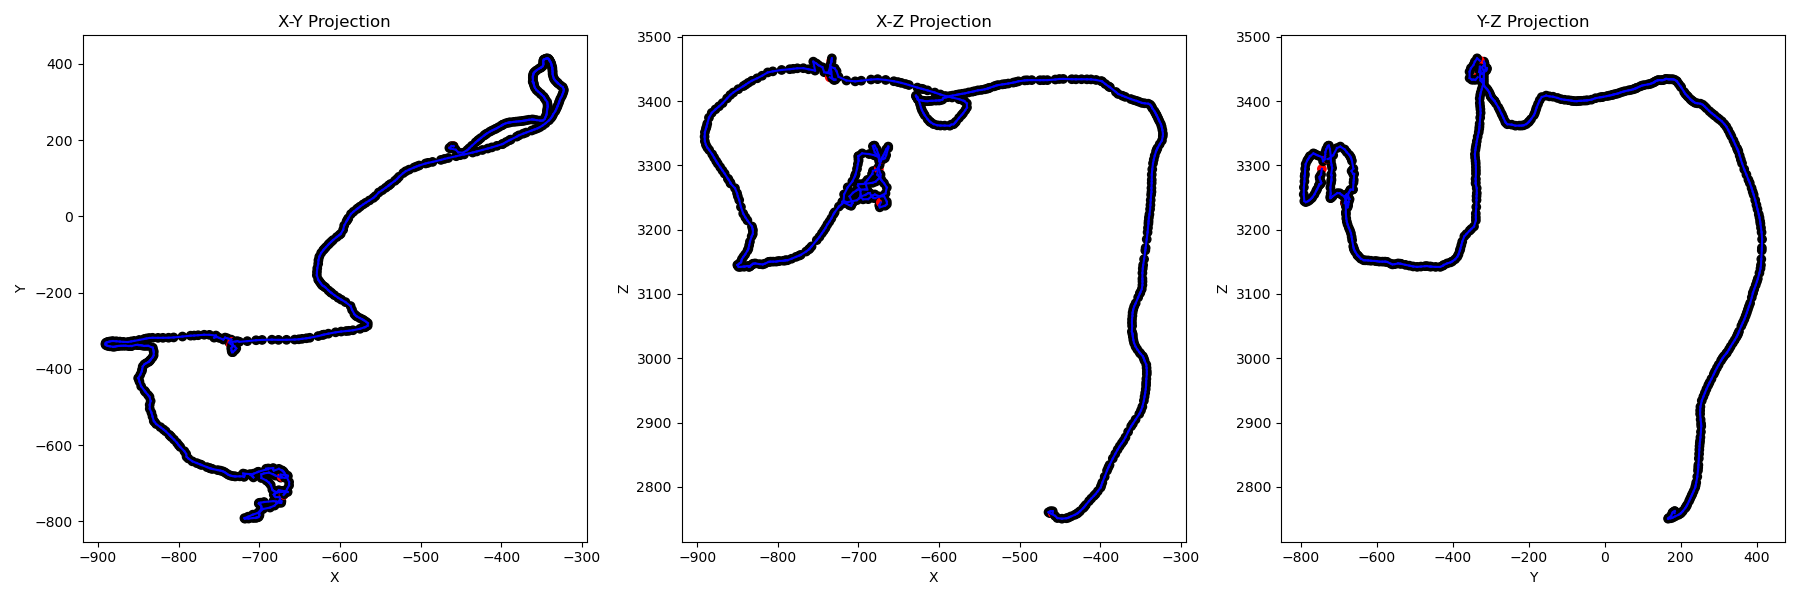

In [203]:
%matplotlib widget

data = hits[hits.event_id ==69904]

# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
data = data[['x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

display(data)

df = pd.DataFrame(data)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

# Initialize connections counter, keeps track of number of connections to each index
connection_count = np.zeros(len(data), dtype=int)

# This is a dict, format is
# index : [connected node 1, connected node 2,...]
connected_nodes = {}
connections = []

# Tunable parameters
init_dist_thresh = 15 # max distance for initial connections [mm]
incr_dist_thresh = [2,4,6,8,10,12,14,16,18,20] # Second stage, look for closest nodes, then slowly increase threshold [mm]
dist_threshold = 15 # Third distance threshold for conecting end nodes [mm]


for i in range(len(data)):
    # Find the index of the closest node (excluding itself)
    # closest_idx = np.argpartition(dist_matrix[i], 1)[1]
    closest_idx = np.argsort(dist_matrix[i])[1]
    
    # Check if the connection already exists 
    if closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []):

        # Check the proposed node has 0 or 1 connection
        if (connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and dist_matrix[i][closest_idx] < init_dist_thresh):
            
            cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
            
            # Add connection between node i and closest_idx if it doesnt form a cycle
            if (not cycle):
                UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

# Incrementally loop over distance steps looking for connections
# starting from a small step size helps lock onto the nearest nodes
for dist in incr_dist_thresh:

    # Connect single nodes to the next closest single node
    for i in single_nodes:
        
        # Connections get updated, so this ensures we dont make a connection to a newly formed connection
        if connection_count[i] == 1:
            
            # Find the index of the closest node with one connection (excluding itself)
            sorted_indices = np.argsort(dist_matrix[i])[1:]
            
            for closest_idx in sorted_indices[:dist]:

                # Check if the index is not itelf and the connection count of the closest index is 1
                if closest_idx != i and connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []): 
                    
                    if dist_matrix[i][closest_idx] < dist:

                        cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
                        
                        if not cycle:
                            UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)
                            break




# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
    ax.scatter(x, y, c=colors, marker='o')
    for connection in connections:
        start_node = connection[0]
        end_node = connection[1]
        ax.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'b-')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot xy projection
plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()

{'id': 0, 'start': 119, 'end': 125, 'nodes': [119, 131, 135, 132, 129, 124, 123, 121, 127, 128, 125], 'length': 72.887, 'energy': 0.0748500000590866, 'label': 'track', 'c': (0.10588235294117647, 0.6196078431372549, 0.4666666666666667)}
{'id': 2, 'start': 219, 'end': 231, 'nodes': [219, 230, 229, 216, 208, 196, 181, 171, 165, 164, 172, 174, 177, 173, 170, 160, 152, 146, 142, 143, 147, 153, 156, 158, 161, 163, 169, 167, 166, 168, 179, 189, 200, 209, 218, 223, 222, 217, 205, 202, 197, 203, 204, 210, 221, 228, 225, 213, 211, 214, 232, 234, 240, 249, 245, 220, 207, 201, 199, 192, 190, 187, 184, 176, 175, 180, 188, 194, 206, 227, 241, 250, 251, 244, 226, 224, 231], 'length': 495.078, 'energy': 0.4594500007788156, 'label': 'track', 'c': (0.8509803921568627, 0.37254901960784315, 0.00784313725490196)}
{'id': 4, 'start': 237, 'end': 352, 'nodes': [237, 238, 242, 248, 252, 253, 247, 243, 239, 236, 235, 233, 215, 198, 193, 195, 186, 183, 185, 182, 162, 159, 155, 149, 154, 151, 150, 148, 140, 144, 

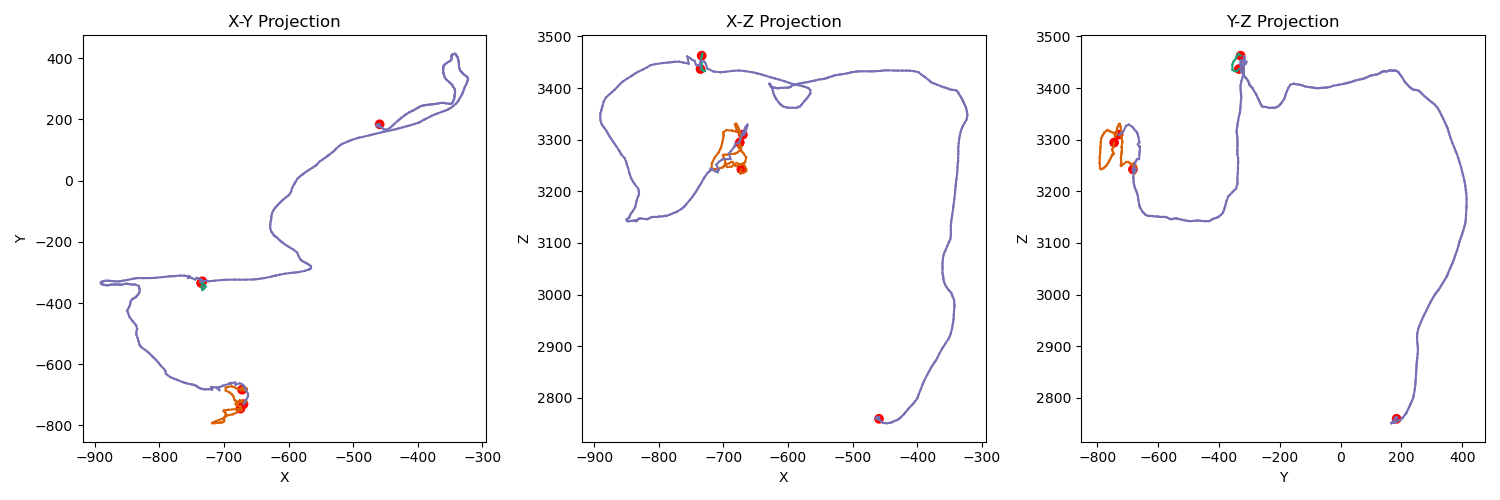

In [194]:
# Track building
colormap = plt.cm.get_cmap('Dark2')
color_cycle = itertools.cycle(colormap.colors)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

Tracks = []

for i,node in enumerate(single_nodes):
    # Check that the track hasnt already been added
    if (check_start_end_exists(node,Tracks)):
        continue

    # Get the track path
    path = GetNodePath(connected_nodes, node, connected_nodes[node][0])

    total_length, total_energy = GetTrackLengthEnergy(path, data)
    color = next(color_cycle)

    Track = {"id":i, "start":path[0], "end":path[-1], "nodes":path, "length":total_length, "energy":total_energy,"label":"track","c":color}
    Tracks.append(Track)


for t in Tracks:
    print(t)

# Function to plot connections
def plot_tracks(ax, x, y, connection_count, x_label, y_label, Tracks_):
    # Filter data for markers with count 1 or 0
    filtered_indices = [i for i, count in enumerate(connection_count) if count == 1 or count == 0 or count == 3]
    filtered_x = [x[i] for i in filtered_indices]
    filtered_y = [y[i] for i in filtered_indices]
    
    # # Define colors for filtered data
    colors = [None] * len(filtered_indices)
    for index, i in enumerate(filtered_indices):
        if connection_count[i] == 1:
            colors[index] = "r"
        elif (connection_count[i] == 0):
            colors[index] = "Orange"
        else:
            colors[index] = "DarkGreen"

    
    # Plot filtered markers
    ax.scatter(filtered_x, filtered_y, c=colors, marker='o')

    # Plot connections
    for Track in Tracks_:
        for i, connection in enumerate(Track["nodes"]):
            if i == len(Track["nodes"]) - 1:
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i + 1]

            ax.plot([x[start_node], x[end_node]],
                    [y[start_node], y[end_node]], color=Track["c"], linestyle="-")
            
        if (Track["label"] == "vertex"):
            ax.plot(x[Track["start"]], y[Track["start"]], marker = "x", color = "r" )
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', Tracks)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', Tracks)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', Tracks)

plt.tight_layout()
plt.show()

In [195]:
print(GetMeanNodeDist(Tracks, data))

dist_threshold = 4*GetMeanNodeDist(Tracks, data)
# dist_threshold = 10

6.708


In [196]:
# Now look to merge tracks that are close by and identify deltas

# Add in any nodes without connections to the tracks as gammas and re-label other tracks as gammas
AddConnectionlessNodes(connection_count, Tracks, data)


# search connections made and make sure to get the merged id
def GetDaughterConnectionID(id_, dict_):
    for ids in dict_:
        if (ids == id_):
            return GetDaughterConnectionID(dict_[id_], dict_)
        
    print("Daughter ID is: ",id_)
    return id_

# This is
def AddConnectedTracks(curr_track,conn_track, delta_path, seg1_path, seg2_path, UpdatedTracks, data):

    # Get the ids before popping
    delta_id   = GetUniqueTrackID(UpdatedTracks)
    primary_id =  GetUniqueTrackID(UpdatedTracks)+1

    # Remove the old tracks from the array
    for index, t in enumerate(UpdatedTracks):
        
        # remove the old tracks
        if (t["id"] == curr_track):
            UpdatedTracks.pop(index)

    # Remove the old tracks from the array
    for index, t in enumerate(UpdatedTracks):
        # remove the old tracks
        if (t["id"] == conn_track):
            UpdatedTracks.pop(index)


    delta_len, delta_e = GetTrackLengthEnergy(delta_path, data)
    Delta = {"id":delta_id, "start":delta_path[0], "end":delta_path[-1], "nodes":delta_path, "length":delta_len, "energy":delta_e,"label":"delta","c":"darkred"}
    UpdatedTracks.append(Delta)
    
    joined_track_path = join_tracks(seg1_path, seg2_path)
    total_length_joined, total_energy_joined = GetTrackLengthEnergy(joined_track_path, data)
    color = next(color_cycle)
    
    Primary = {"id":primary_id, "start":joined_track_path[0], "end":joined_track_path[-1], "nodes":joined_track_path, "length":total_length_joined, "energy":total_energy_joined,"label":"track","c":color}
    UpdatedTracks.append(Primary)


# Update an existing track in the updated tracks array from the merging of two tracks
def UpdateAndMergeTrack(curr_track,conn_track, newpath, UpdatedTracks_, data):

    name=""
    color = "yellow"
    primary_id = GetUniqueTrackID(UpdatedTracks_)
    
    for index, t in enumerate(UpdatedTracks_):
        
        # Remove the old tracks from the array
        for index, t in enumerate(UpdatedTracks_):
            
            # remove the old tracks
            if (t["id"] == curr_track):
                UpdatedTracks_.pop(index)

        # Remove the old tracks from the array
        for index, t in enumerate(UpdatedTracks_):
            # remove the old tracks
            if (t["id"] == conn_track):
                name=t["label"]
                color = t["c"]
                UpdatedTracks_.pop(index)

    # Add the new merged track
    length, energy = GetTrackLengthEnergy(newpath, data)
    print(newpath[0], newpath[-1], newpath)
    Primary = {"id":primary_id, "start":newpath[0], "end":newpath[-1], "nodes":newpath, "length":length, "energy":energy,"label":name,"c":color}
    UpdatedTracks_.append(Primary)


# def ConnectTracks(Tracks_):
#     # UpdatedTracks = []
#     UpdatedTracks = copy.deepcopy(Tracks_)


#     for idx, Track in enumerate(Tracks_):

#         # for t in UpdatedTracks:
#         #     print(t)

#         # Check if the track has been previously merged, if it has then consider the merged track instead
#         curr_track = Track["id"]
#         print(curr_track)

#         print("Num new tracks:", len(UpdatedTracks))
        
#         start_node = Track["start"]
#         end_node   = Track["end"]

#         # Check if the start/end is in the UpdatedTracks and if it matches to a delta
#         # if (SearchDelta(Track, UpdatedTracks)):
#             # print("Track is flagged as a connected delta, skipping...")
#             # continue


#         # dont run this if we only got one track!
#         if (len(Tracks) == 1):
#             return UpdatedTracks

#         # Get the indexes of closest nodes to start and end
#         dist_ind_start = np.argsort(dist_matrix[start_node])[1:]
#         dist_ind_end   = np.argsort(dist_matrix[end_node])[1:]

#         # Filter nodes that are in the current track
#         dist_ind_start = [x for x in dist_ind_start if x not in Track["nodes"]]
#         dist_ind_end   = [x for x in dist_ind_end if x not in Track["nodes"]]

#         # Distances of the end point to the closest track
#         dist_start = dist_matrix[start_node][dist_ind_start[0]]
#         dist_end   = dist_matrix[end_node][dist_ind_end[0]]

#         # apply threshold
#         if (dist_start > dist_threshold and dist_end > dist_threshold):
#             # print("Failed distance requirements")
#             continue

#         # Initialize
#         closest_idx = 0
#         end_conn_node = 0
#         con_point = "start"
#         curr_track_path = Track["nodes"]

#         # Choose the smallest index
#         if dist_start < dist_end or connection_count[dist_ind_end[0]] > 2:
#             closest_idx = dist_ind_start[0]
#             end_conn_node = start_node
            
#         else:
#             closest_idx = dist_ind_end[0]
#             end_conn_node = end_node
#             con_point = "end"

#         if (connection_count[closest_idx] > 2):
#             print("Node already has three connections, skipping,...")
#             continue

#         if (connection_count[end_conn_node] > 2):
#             print("Node already has three connections, skipping,...")
#             continue

#         # Get the track ID where the connecting node is located
#         con_track      = GetTrackwithNode(closest_idx, Tracks)
#         con_track_dict = GetTrackDictwithNode(closest_idx, Tracks)

#         # if node-node then merge nodes and update track in Tracks
#         if (closest_idx == con_track_dict["start"] or closest_idx == con_track_dict["end"]):
            
#             newpath = join_tracks(curr_track_path,con_track_dict["nodes"])
#             UpdateAndMergeTrack(curr_track, con_track, newpath, UpdatedTracks, data)
#             UpdateConnections(closest_idx, end_conn_node, connected_nodes, connections, connection_count)
            
#             # Resart Loop on a new connection
#             ConnectTracks(UpdatedTracks)

#         # Check if the proposed connection will form a cycle
#         cycle  = Testcycle(end_conn_node, closest_idx ,connected_nodes, connections, connection_count)

        
#         if not cycle:

#             if (con_point =="start"):
#                 curr_track_path.insert(0,closest_idx)
#             else:
#                 curr_track_path.append(closest_idx)

#             Track["nodes"] = curr_track_path
#             UpdateConnections(closest_idx, end_conn_node, connected_nodes, connections, connection_count)
#         else:
#             continue

#         # Get the length either side of track
#         seg1_path = GetNodePath(connected_nodes, closest_idx, connected_nodes[closest_idx][0])
#         seg2_path = GetNodePath(connected_nodes, closest_idx, connected_nodes[closest_idx][1])

#         # Now get the lengths and energies of the track segments
#         total_length_seg1, total_energy_seg1 = GetTrackLengthEnergy(seg1_path, data)
#         total_length_seg2, total_energy_seg2 = GetTrackLengthEnergy(seg2_path, data) 
#         total_length_seg3, total_energy_seg3 = GetTrackLengthEnergy(curr_track_path, data) 

#         # Find the delta and the primary track and add them to the new track list
#         if (total_length_seg1 < total_length_seg2 and total_length_seg1 < total_length_seg3):
#             AddConnectedTracks(curr_track, con_track, seg1_path, seg2_path, curr_track_path, UpdatedTracks, data)
        
#         elif ((total_length_seg2 < total_length_seg1 and total_length_seg2 < total_length_seg3)):
#             AddConnectedTracks(curr_track, con_track, seg2_path, seg1_path, curr_track_path, UpdatedTracks, data)
        
#         else:
#             delta_id = GetUniqueTrackID(UpdatedTracks)
            
#             # Remove the old tracks from the array
#             for j, t in enumerate(UpdatedTracks):
                
#                 # remove the old tracks
#                 if (t["id"] == curr_track):
#                     UpdatedTracks.pop(j)

#             # Pop the track and re-add it with the new delta
#             # UpdatedTracks.pop(idx)
#             Delta = {"id":delta_id, "start":curr_track_path[0], "end":curr_track_path[-1], "nodes":curr_track_path, "length":total_length_seg3, "energy":total_energy_seg3,"label":"delta","c":"darkred"}
#             UpdatedTracks.append(Delta)

#         # Resart Loop on a new connection
#         ConnectTracks(UpdatedTracks)

#     return UpdatedTracks

# # Run the functiom
# UpdatedTracks = ConnectTracks(Tracks)


# print("Total Tracks:", len(UpdatedTracks))

# for t in UpdatedTracks:
#     print(t)



In [197]:



# UpdatedTracks = []
UpdatedTracks = copy.deepcopy(Tracks)


for idx, Track in enumerate(Tracks):

    # for t in UpdatedTracks:
    #     print(t)

    # Check if the track has been previously merged, if it has then consider the merged track instead
    curr_track = Track["id"]
    print(curr_track)

    print("Num new tracks:", len(UpdatedTracks))
    
    start_node = Track["start"]
    end_node   = Track["end"]

    # Check if the start/end is in the UpdatedTracks and if it matches to a delta
    # if (SearchDelta(Track, UpdatedTracks)):
        # print("Track is flagged as a connected delta, skipping...")
        # continue


    # dont run this if we only got one track!
    if (len(Tracks) == 1):
        break

    # Get the indexes of closest nodes to start and end
    dist_ind_start = np.argsort(dist_matrix[start_node])[1:]
    dist_ind_end   = np.argsort(dist_matrix[end_node])[1:]

    # Filter nodes that are in the current track
    dist_ind_start = [x for x in dist_ind_start if x not in Track["nodes"]]
    dist_ind_end   = [x for x in dist_ind_end if x not in Track["nodes"]]

    # Distances of the end point to the closest track
    dist_start = dist_matrix[start_node][dist_ind_start[0]]
    dist_end   = dist_matrix[end_node][dist_ind_end[0]]

    # apply threshold
    if (dist_start > dist_threshold and dist_end > dist_threshold):
        print("Failed distance requirements")
        continue

    # Initialize
    closest_idx = 0
    end_conn_node = 0
    con_point = "start"
    curr_track_path = Track["nodes"]

    # Choose the smallest index
    if dist_start < dist_end:
        closest_idx = dist_ind_start[0]
        end_conn_node = start_node
        
    else:
        closest_idx = dist_ind_end[0]
        end_conn_node = end_node
        con_point = "end"

    # Get the track ID where the connecting node is located
    con_track      = GetTrackwithNode(closest_idx, Tracks)

    # Check if that index has changed, use that track
    # temp_con_trackid = GetDaughterConnectionID(con_track)
    con_track_dict = GetTrackDictwithNode(closest_idx, Tracks)

    # if node-node then merge nodes and update track in Tracks
    if (closest_idx == con_track_dict["start"] or closest_idx == con_track_dict["end"]):
         
        newpath = join_tracks(curr_track_path,con_track_dict["nodes"])
        UpdateAndMergeTrack(curr_track, con_track, newpath, UpdatedTracks, data)
        UpdateConnections(closest_idx, end_conn_node, connected_nodes, connections, connection_count)
        continue

    # Check if the proposed connection will form a cycle
    cycle  = Testcycle(end_conn_node, closest_idx ,connected_nodes, connections, connection_count)

    
    if not cycle:

        if (con_point =="start"):
            curr_track_path.insert(0,closest_idx)
        else:
            curr_track_path.append(closest_idx)

        Track["nodes"] = curr_track_path
        UpdateConnections(closest_idx, end_conn_node, connected_nodes, connections, connection_count)
    else:
        continue

    # Get the length either side of track
    seg1_path = GetNodePath(connected_nodes, closest_idx, connected_nodes[closest_idx][0])
    seg2_path = GetNodePath(connected_nodes, closest_idx, connected_nodes[closest_idx][1])

    # Now get the lengths and energies of the track segments
    total_length_seg1, total_energy_seg1 = GetTrackLengthEnergy(seg1_path, data)
    total_length_seg2, total_energy_seg2 = GetTrackLengthEnergy(seg2_path, data) 
    total_length_seg3, total_energy_seg3 = GetTrackLengthEnergy(curr_track_path, data) 

    # Find the delta and the primary track and add them to the new track list
    if (total_length_seg1 < total_length_seg2 and total_length_seg1 < total_length_seg3):
        AddConnectedTracks(curr_track, con_track, seg1_path, seg2_path, curr_track_path, UpdatedTracks, data)
    
    elif ((total_length_seg2 < total_length_seg1 and total_length_seg2 < total_length_seg3)):
        AddConnectedTracks(curr_track, con_track, seg2_path, seg1_path, curr_track_path, UpdatedTracks, data)
        print(seg1_path)
        print(seg2_path)
        print(curr_track_path)
    
    else:

        delta_id = GetUniqueTrackID(UpdatedTracks)
        
        # Remove the old tracks from the array
        for j, t in enumerate(UpdatedTracks):
            
            # remove the old tracks
            if (t["id"] == curr_track):
                UpdatedTracks.pop(j)

        
        # Pop the track and re-add it with the new delta
        # UpdatedTracks.pop(idx)
        Delta = {"id":delta_id, "start":curr_track_path[0], "end":curr_track_path[-1], "nodes":curr_track_path, "length":total_length_seg3, "energy":total_energy_seg3,"label":"delta","c":"darkred"}
        UpdatedTracks.append(Delta)

    for t in UpdatedTracks:
        print(t)

print("Total Tracks:", len(UpdatedTracks))

for t in UpdatedTracks:
    print(t)




0
Num new tracks: 3
{'id': 2, 'start': 219, 'end': 231, 'nodes': [219, 230, 229, 216, 208, 196, 181, 171, 165, 164, 172, 174, 177, 173, 170, 160, 152, 146, 142, 143, 147, 153, 156, 158, 161, 163, 169, 167, 166, 168, 179, 189, 200, 209, 218, 223, 222, 217, 205, 202, 197, 203, 204, 210, 221, 228, 225, 213, 211, 214, 232, 234, 240, 249, 245, 220, 207, 201, 199, 192, 190, 187, 184, 176, 175, 180, 188, 194, 206, 227, 241, 250, 251, 244, 226, 224, 231], 'length': 495.078, 'energy': 0.4594500007788156, 'label': 'track', 'c': (0.8509803921568627, 0.37254901960784315, 0.00784313725490196)}
{'id': 4, 'start': 237, 'end': 352, 'nodes': [237, 238, 242, 248, 252, 253, 247, 243, 239, 236, 235, 233, 215, 198, 193, 195, 186, 183, 185, 182, 162, 159, 155, 149, 154, 151, 150, 148, 140, 144, 141, 139, 138, 133, 130, 126, 118, 116, 114, 112, 110, 109, 107, 103, 102, 101, 99, 97, 96, 94, 92, 90, 89, 88, 87, 85, 84, 83, 82, 80, 79, 78, 76, 75, 73, 71, 70, 69, 62, 61, 57, 56, 59, 55, 50, 46, 45, 37, 34, 32, 

In [198]:
for c in connection_count:
    if (c>2):print(c)

3
3
3


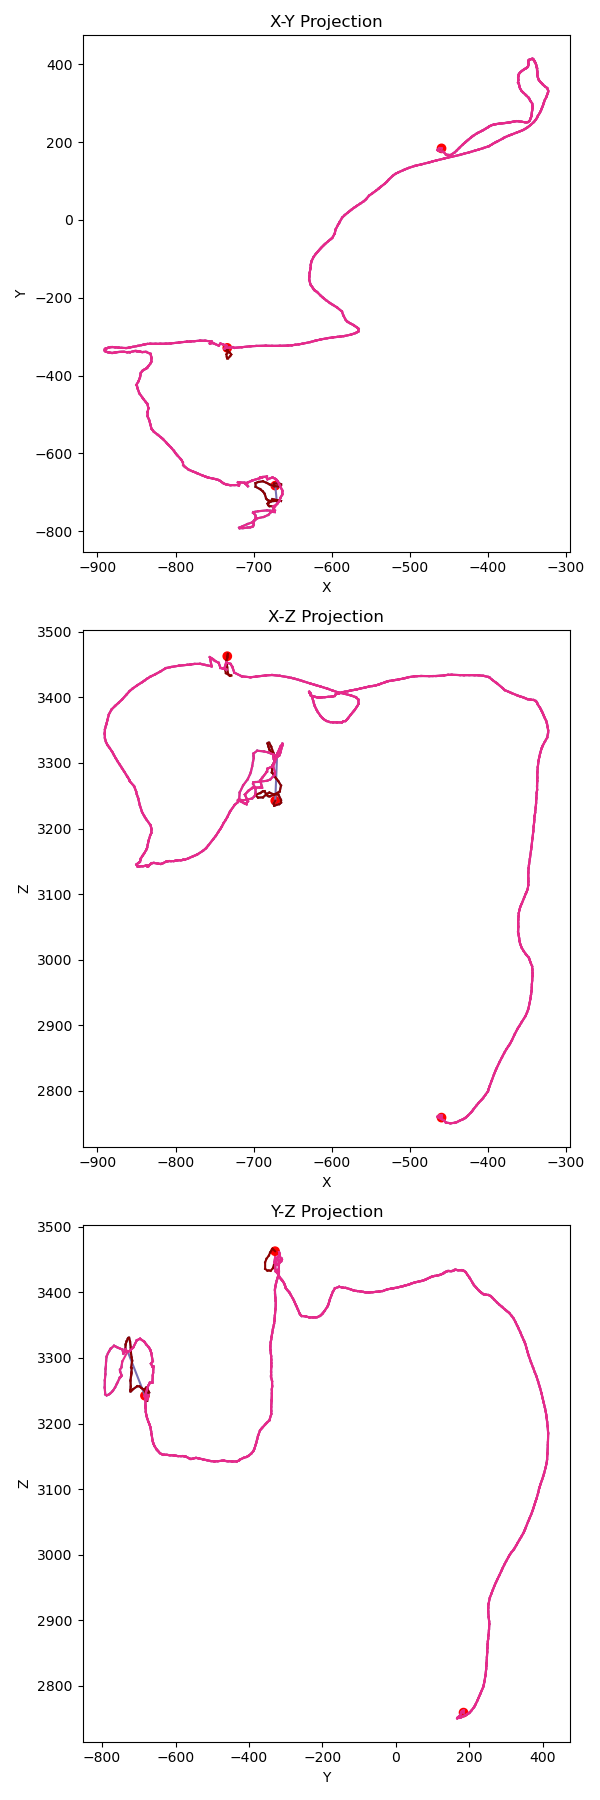

In [199]:
# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    # Filter data for markers with count 1 or 0
    filtered_indices = [i for i, count in enumerate(connection_count) if count == 1 or count == 0]
    filtered_x = [x[i] for i in filtered_indices]
    filtered_y = [y[i] for i in filtered_indices]
    
    # Define colors for filtered data
    colors = ['r' for count in filtered_indices]
    
    # Plot filtered markers
    ax.scatter(filtered_x, filtered_y, c=colors, marker='o')

    # Plot connections
    for Track in UpdatedTracks:
        for i, connection in enumerate(Track["nodes"]):
            if i == len(Track["nodes"]) - 1:
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i + 1]

            ax.plot([x[start_node], x[end_node]],
                    [y[start_node], y[end_node]], color=Track["c"], linestyle="-")
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')


# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 18))

# Plot xy projection
plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()

In [200]:
# Get the track with the most nodes, this is taken to be the primary

num_nodes = 0
primary_track_id = -1
primary_nodes = []

for t in UpdatedTracks:
    if ( len(t["nodes"]) > num_nodes):
        num_nodes = len(t["nodes"])
        primary_track_id = t["id"]
        primary_nodes = t["nodes"]

print("The primary track is: ", primary_track_id)



Primary_Track = data.reindex(primary_nodes)


# Take the mean every ten rows
# Primary_Track = Primary_Track.groupby(np.arange(len(Primary_Track)) // 10).mean()


display(Primary_Track)


# Function to calculate the Euclidean distance between two points
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

# Function to calculate the angle between two vectors
def angle_between_vectors(v1, v2):
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    # Ensure the value is within [-1, 1] due to floating-point precision
    cos_theta = np.clip(cos_theta, -1, 1)
    angle = np.arccos(cos_theta)
    return np.degrees(angle)


# Get the diff between each row
distances = [0]
for i in range(1, len(Primary_Track)):
    
    prev_point = Primary_Track.iloc[i - 1][['x', 'y', 'z']].to_numpy()
    curr_point = Primary_Track.iloc[i][['x', 'y', 'z']].to_numpy()
    distances.append(euclidean_distance(curr_point,prev_point))


cum_distance = []
sum_ = 0
for d in distances:
    sum_ = sum_+d
    cum_distance.append(sum_)

cum_distance = np.array(cum_distance)


angles = [0]  # First point has no preceding point for angle calculation

# Iterate through the points
for i in range(1, len(Primary_Track)):
    # Current and previous points
    prev_point = Primary_Track.iloc[i - 1][['x', 'y', 'z']].to_numpy()
    curr_point = Primary_Track.iloc[i][['x', 'y', 'z']].to_numpy()
    
    
    # Calculate angle between the vectors
    if i > 1:  # Skip the first vector, as there's no previous vector
        prev_vector = prev_point - Primary_Track.iloc[i - 2][['x', 'y', 'z']].to_numpy()
        curr_vector = curr_point - prev_point

        angle = angle_between_vectors(prev_vector, curr_vector)
        angles.append(angle)
    else:
        angles.append(0)  # No angle for the first vector

# Add the cumulative distances and angles as new columns
Primary_Track['cumulative_distance'] = cum_distance
Primary_Track['angle'] = angles

Primary_Track.reset_index(drop=True, inplace=True)
pd.set_option('display.max_rows', 100)
display(Primary_Track)




The primary track is:  8


,x,y,z,energy
217,-674.997681,-736.488342,3313.296631,0.005225
222,-674.378540,-737.860840,3309.248535,0.002375
223,-674.257446,-741.834717,3306.387207,0.034100
218,-674.855225,-744.682373,3312.829102,0.010075
209,-678.281616,-752.567383,3314.661621,0.001250
...,...,...,...,...
248,-665.615295,-715.135010,3315.876465,0.004650
242,-667.124207,-723.441345,3311.262939,0.006725
238,-669.098877,-728.327271,3309.913818,0.000950
237,-669.902405,-730.262268,3309.885254,0.000050


,x,y,z,energy,cumulative_distance,angle
0,-674.997681,-736.488342,3313.296631,0.005225,0.000000,0.000000
1,-674.378540,-737.860840,3309.248535,0.002375,4.319046,0.000000
2,-674.257446,-741.834717,3306.387207,0.034100,9.217369,36.016531
3,-674.855225,-744.682373,3312.829102,0.010075,16.285925,101.982705
4,-678.281616,-752.567383,3314.661621,0.001250,25.076355,54.245248
...,...,...,...,...,...,...
863,-665.615295,-715.135010,3315.876465,0.004650,6036.834013,34.512274
864,-667.124207,-723.441345,3311.262939,0.006725,6046.454649,18.891726
865,-669.098877,-728.327271,3309.913818,0.000950,6051.894476,17.947549
866,-669.902405,-730.262268,3309.885254,0.000050,6053.989873,13.589287


Text(0, 0.5, 'Scatter Angle [deg]')

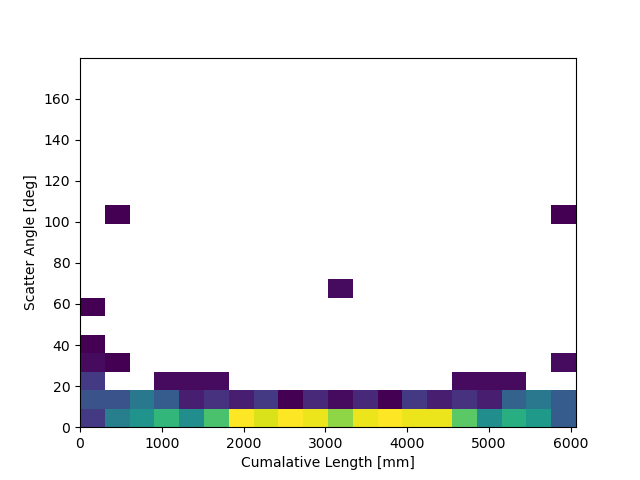

In [201]:
plt.figure()
# plt.scatter(Primary_Track.x, Primary_Track.z)

# plt.scatter(Primary_Track.index, Primary_Track.angle)

# plt.hist(Primary_Track.angle)
# plt.semilogy()
plt.hist2d(Primary_Track.cumulative_distance, Primary_Track.angle, bins = 20,cmin=3);

# plt.scatter(Primary_Track.cumulative_distance, Primary_Track.angle);

# plt.scatter(Primary_Track.cumulative_distance, Primary_Track.angle)

plt.xlabel("Cumalative Length [mm]")
plt.ylabel("Scatter Angle [deg]")

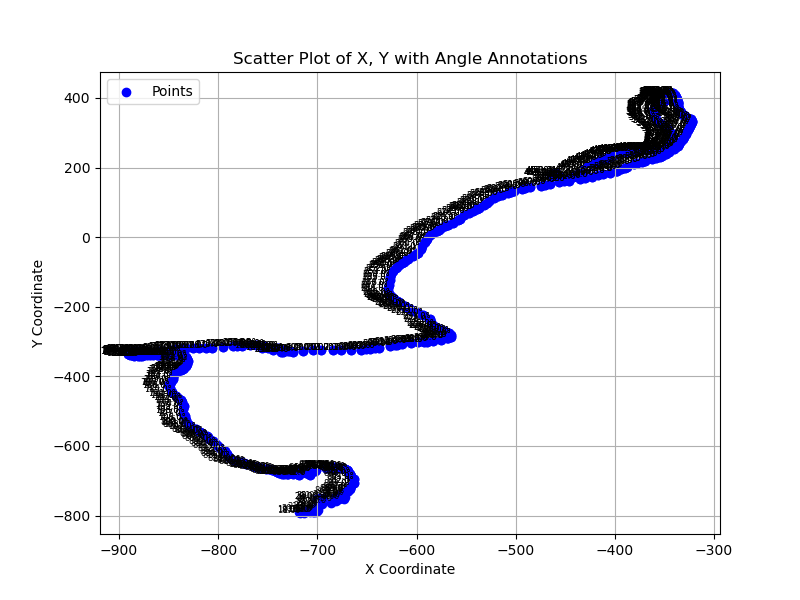

In [202]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(Primary_Track['x'], Primary_Track['y'], color='blue', label='Points')

# Annotate each point with the corresponding angle
for i in range(len(Primary_Track)):
    x = Primary_Track.loc[i, 'x']
    y = Primary_Track.loc[i, 'y']
    # angle = Primary_Track.loc[i, 'angle']
    angle = i
    
    # Only annotate if angle is not NaN
    if not np.isnan(angle):
        plt.text(x, y, f'{angle:.1f}°', fontsize=6, ha='right')

# Additional plot settings
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of X, Y with Angle Annotations')
plt.legend()
plt.grid(True)

# Show plot
plt.show()